# Dataflow

AnnData (PY) is used as the datastructure to handle the single cell data.

Anndata2ri is used to convert AnnData, python object, to SingleCellExperiment object, R object, which can be processed by Seurat that runs in python enabled by rpy2.

Seurat is used for data normalization (`SCTransform`), and integration of different stages (`FindIntegrationAnchors` and `IntegrateData`).

Processed data will be transfered back to AnnData object in python.

Scanpy is used for data visualization due to its rich plotting functionalities.

# Setup

Setting up the above workflow in jupyter using Conda

```
# R=4.0.5 is required for compatibilities between Anndata2ri=1.0.5 and rpy2=3.4.2
# see https://github.com/theislab/anndata2ri/issues/63
conda create -n scRNA -c conda-forge r-essentials r-base=4.0
conda activate scRNA

# install seurat
# start R
install.packages("Seurat")
if (!requireNamespace("BiocManager", quietly = TRUE)) install.packages("BiocManager")
BiocManager::install("glmGamPoi")

# Anndata, Anndata2ri, and Scanpy
pip install 'rpy2==3.4.2'
pip install anndata2ri
conda install seaborn scikit-learn statsmodels numba pytables
conda install -c conda-forge python-igraph leidenalg 
conda install -c bioconda scanpy

# jupyter
conda install ipykernel nb_black 
python -m ipykernel install --user --name scrna --display-name "scrna"
```

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
import anndata2ri
from scipy.sparse import coo_matrix, csr_matrix

In [3]:
# Activate the anndata2ri conversion between SingleCellExperiment and AnnData
anndata2ri.activate()

# Loading the rpy2 extension enables cell magic to be used
# This runs R code in jupyter notebook cells
%load_ext rpy2.ipython

# sc.logging.print_versions()
sc.settings.verbosity = 3

In [4]:
%%R
library(Seurat)
library(repr)
options(repr.plot.width=15, repr.plot.height=8)

R[write to console]: Attaching SeuratObject



# Identify PrE Cells in E4.5 scRNA Dataset 

In [5]:
e45_sc_tbl = pd.concat(
    [
        pd.read_csv(
            "singlecell_counts/E4.5/GSM3494336_Lib1-1_E4.5_counts.csv.gz", sep=","
        ),
        pd.read_csv(
            "singlecell_counts/E4.5/GSM3494337_Lib1-2_E4.5_counts.csv.gz", sep=","
        ),
    ],
    axis=0,
).fillna(0)

e45_sc_tbl.head(3)

,Unnamed: 0,0610007P14RIK,0610009B22RIK,0610009L18RIK,0610009O20RIK,0610010F05RIK,0610010K14RIK,0610012G03RIK,0610030E20RIK,0610037L13RIK,...,ZFP869,ZFP872,ZFP957,ZFP964,ZG16,ZGLP1,ZKSCAN2,ZMAT1,ZSCAN5B,ZYG11A
0,b'TTTGTCATCCAGATCA',0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,b'TTTCCTCAGTCGCCGT',0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,b'TTAGTTCGTTTGGGCC',0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Create AnnData object

In [6]:
e45_sc_adata = ad.AnnData(csr_matrix(e45_sc_tbl.iloc[:, 1:]), dtype=np.float64)
e45_sc_adata.obs_names = e45_sc_tbl.iloc[:, 0].values
e45_sc_adata.var_names = e45_sc_tbl.columns[1:].values
e45_sc_adata.obs["Cell_ID"] = [f"Cell_{i:d}" for i in range(e45_sc_adata.n_obs)]
e45_sc_adata

AnnData object with n_obs × n_vars = 690 × 16030
    obs: 'Cell_ID'

In [54]:
%%R -i e45_sc_adata
e45_sc_seurat = as.Seurat(e45_sc_adata, counts="X", data=NULL)
e45_sc_seurat

/home/coco/miniconda3/envs/scRNA/lib/python3.10/site-packages/anndata2ri/r2py.py:102: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)


An object of class Seurat 
16030 features across 690 samples within 1 assay 
Active assay: originalexp (16030 features, 0 variable features)


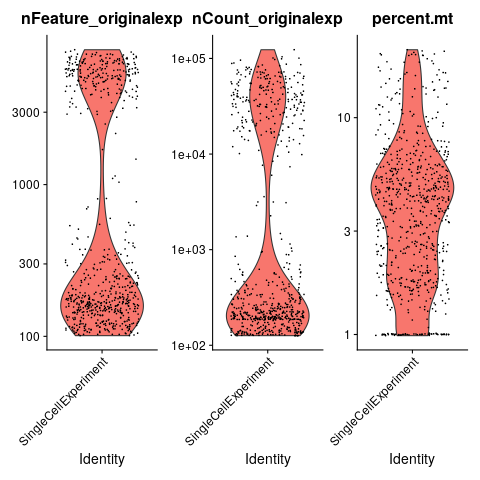

In [55]:
%%R
e45_sc_seurat <- PercentageFeatureSet(e45_sc_seurat, pattern = "^MT-", col.name = "percent.mt")
VlnPlot(e45_sc_seurat, features = c("nFeature_originalexp", "nCount_originalexp", "percent.mt"), ncol = 3, log=TRUE)

In [57]:
%%R
e45_sc_seurat <- subset(e45_sc_seurat, subset = nFeature_originalexp > 500 & nFeature_originalexp < 8000 & percent.mt < 10)
e45_sc_seurat <- SCTransform(e45_sc_seurat, assay="originalexp", verbose = FALSE, vars.to.regress = c("percent.mt"))
e45_sc_seurat

R[write to console]: Error in SCTransform(e45_sc_seurat, assay = "originalexp", verbose = FALSE,  : 
  problem with second non-regularized linear regression; not all variables found in seurat object meta data; check vars.to.regress parameter




Error in SCTransform(e45_sc_seurat, assay = "originalexp", verbose = FALSE,  : 
  problem with second non-regularized linear regression; not all variables found in seurat object meta data; check vars.to.regress parameter


R[write to console]: Spectral initialization failed to converge, using random initialization instead



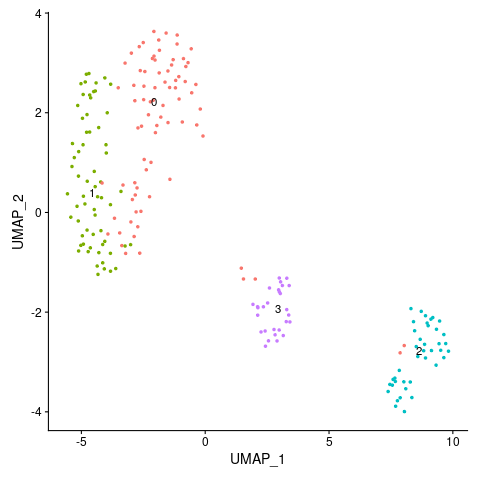

In [50]:
%%R
# These are now standard steps in the Seurat workflow for visualization and clustering
e45_sc_seurat <- RunPCA(e45_sc_seurat, verbose = FALSE)
e45_sc_seurat <- RunUMAP(e45_sc_seurat, dims = 1:30, verbose = FALSE)

e45_sc_seurat <- FindNeighbors(e45_sc_seurat, dims = 1:30, verbose = FALSE)
e45_sc_seurat <- FindClusters(e45_sc_seurat, verbose = FALSE)
DimPlot(e45_sc_seurat, label = TRUE) + NoLegend()

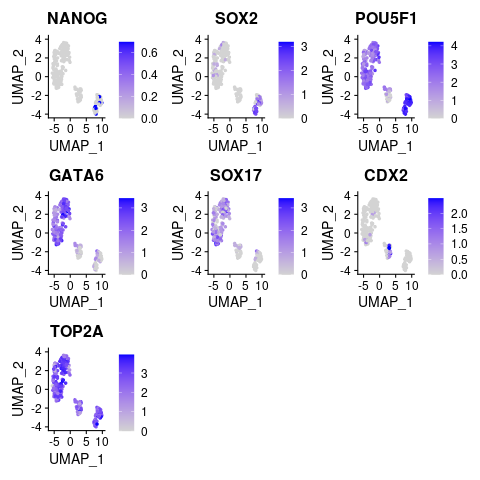

In [53]:
%%R
FeaturePlot(e45_sc_seurat, features=c("NANOG", "SOX2", "POU5F1", "GATA6", "SOX17", "CDX2", "TOP2A"))

In [39]:
cell_gene_tbls = {
    # "E4.5_1": "singlecell_counts/E4.5/GSM3494336_Lib1-1_E4.5_counts.csv.gz",
    # "E4.5_2": "singlecell_counts/E4.5/GSM3494337_Lib1-2_E4.5_counts.csv.gz",
    # "E5.5_1": "singlecell_counts/E5.5/GSM3494338_Lib2-1_E5.5_counts.csv.gz",
    "E5.5_2": "singlecell_counts/E5.5/GSM3494339_Lib2-2_E5.5_counts.csv.gz",
    "E5.5_3": "singlecell_counts/E5.5/GSM3494340_Lib2-3_E5.5_counts.csv.gz",
}

In [40]:
adata = None
for _stage, f in cell_gene_tbls.items():
    stage, rep = _stage.split("_")
    sc_data = pd.read_csv(f, sep=",")
    _adata = ad.AnnData(csr_matrix(sc_data.iloc[:, 1:]), dtype=np.float32)
    # obs dimension
    # _adata.obs_names = [f"Cell_{i:d}" for i in range(cell_cnt, cell_cnt + _adata.n_obs)]
    _adata.obs_names = [f"{_stage}_{i:d}" for i in range(_adata.n_obs)]
    _adata.obs["barcode"] = sc_data.iloc[:, 0].values
    _adata.obs["Stage"] = stage
    _adata.obs["Rep"] = rep
    # var dimension
    _adata.var_names = sc_data.columns[1:].values
    adata = _adata if adata is None else ad.concat([adata, _adata], join="outer")

In [41]:
%%R -i adata
adata_seurat = as.Seurat(adata, counts="X", data=NULL)
adata_seurat

/home/coco/miniconda3/envs/scRNA/lib/python3.10/site-packages/anndata2ri/r2py.py:102: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)


An object of class Seurat 
19660 features across 17831 samples within 1 assay 
Active assay: originalexp (19660 features, 0 variable features)


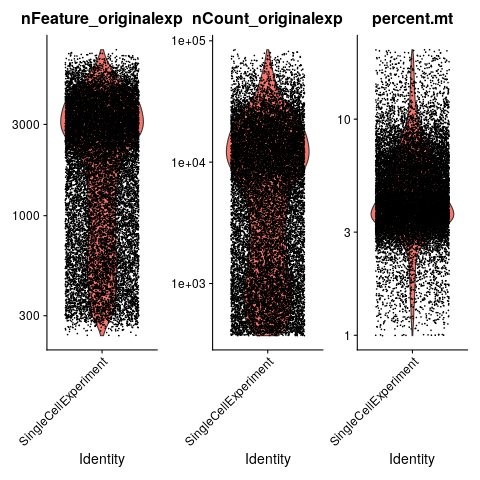

In [42]:
%%R 
adata_seurat <- PercentageFeatureSet(adata_seurat, pattern = "^MT-", col.name = "percent.mt")
VlnPlot(adata_seurat, features = c("nFeature_originalexp", "nCount_originalexp", "percent.mt"), ncol = 3, log=TRUE)

In [43]:
%%R
adata_seurat <- subset(adata_seurat, subset = nFeature_originalexp > 500 & nFeature_originalexp < 8000 & percent.mt < 10)
adata_seurat <- SCTransform(adata_seurat, assay="originalexp", verbose = FALSE, method = "glmGamPoi", vars.to.regress = c("percent.mt", "Rep"))
adata_seurat

An object of class Seurat 
36826 features across 15172 samples within 2 assays 
Active assay: SCT (17166 features, 3000 variable features)
 1 other assay present: originalexp


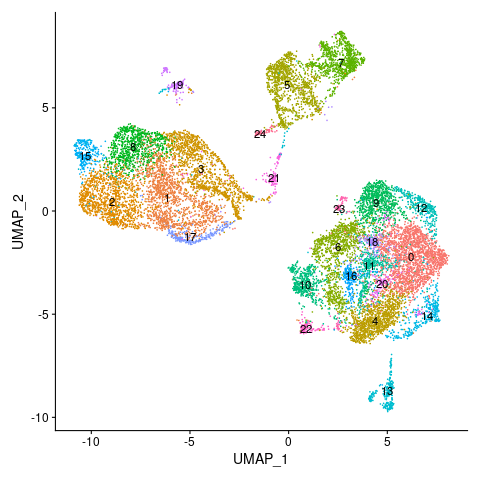

In [44]:
%%R
# These are now standard steps in the Seurat workflow for visualization and clustering
adata_seurat <- RunPCA(adata_seurat, verbose = FALSE)
adata_seurat <- RunUMAP(adata_seurat, dims = 1:30, verbose = FALSE)

adata_seurat <- FindNeighbors(adata_seurat, dims = 1:30, verbose = FALSE)
adata_seurat <- FindClusters(adata_seurat, verbose = FALSE)
DimPlot(adata_seurat, label = TRUE) + NoLegend()

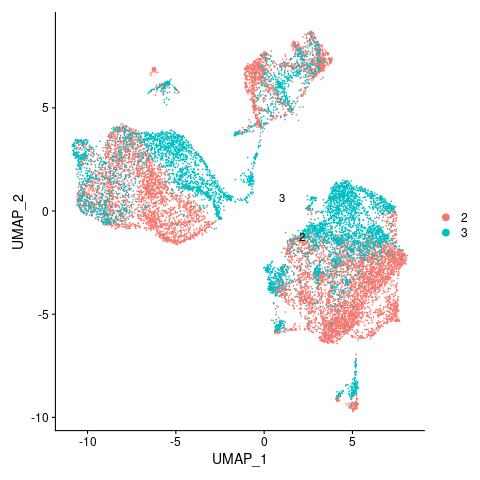

In [45]:
%%R
Idents(adata_seurat) <- "Rep"
DimPlot(adata_seurat, label = TRUE)

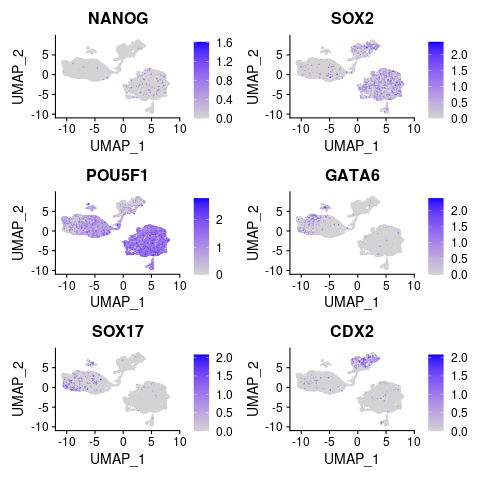

In [46]:
%%R
FeaturePlot(adata_seurat, features=c("NANOG", "SOX2", "POU5F1", "GATA6", "SOX17", "CDX2"))

# E8.5

In [83]:
def make_adata(data_path):
    adata = None
    for _stage, f in cell_gene_tbls.items():
        stage, rep = _stage.split("_")
        sc_data = pd.read_csv(f, sep=",")
        _adata = ad.AnnData(csr_matrix(sc_data.iloc[:, 1:]), dtype=np.float32)
        # obs dimension
        # _adata.obs_names = [f"Cell_{i:d}" for i in range(cell_cnt, cell_cnt + _adata.n_obs)]
        _adata.obs_names = [f"{_stage}_{i:d}" for i in range(_adata.n_obs)]
        _adata.obs["barcode"] = sc_data.iloc[:, 0].values
        _adata.obs["Stage"] = stage
        _adata.obs["Rep"] = rep
        # var dimension
        _adata.var_names = sc_data.columns[1:].values
        adata = _adata if adata is None else ad.concat([adata, _adata], join="outer")
    return adata

In [84]:
e875_ParE_adata = make_adata(
    {
        "E8.75ParE_1": "singlecell_counts/E8.75/E8.75_ParE/GSM3494351_Lib7-1_E8.75_ParE_counts.csv.gz"
    }
)

In [85]:
e875_VE_adata = make_adata(
    {
        "E8.75VE_2": "singlecell_counts/E8.75/E8.75_VE_gfp/GSM3494356_Lib11-2_E8.75_GFP+_counts.csv.gz",
    }
)

In [87]:
import rpy2.robjects as robjects

In [103]:
robjects.r["adata"]

/home/coco/miniconda3/envs/scRNA/lib/python3.10/site-packages/anndata2ri/r2py.py:102: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)


AnnData object with n_obs × n_vars = 23146 × 21321
    obs: 'barcode', 'Stage', 'Rep'

In [106]:
anndata2ri.py2r.py2rpy_anndata(adata)

<rpy2.robjects.methods.RS4 object at 0x7fede1b6d180> [RTYPES.S4SXP]
R classes: ('SingleCellExperiment',)

In [91]:
%%R
adata

/home/coco/miniconda3/envs/scRNA/lib/python3.10/site-packages/anndata2ri/r2py.py:102: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)


class: SingleCellExperiment 
dim: 21321 23146 
metadata(0):
assays(1): X
rownames(21321): 0610007P14RIK 0610009B22RIK ... ZZEF1 ZZZ3
rowData names(0):
colnames(23146): E8.75VE_2_0 E8.75VE_2_1 ... E8.75ParE_1_14083
  E8.75ParE_1_14084
colData names(3): barcode Stage Rep
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [86]:
%%R -i e875_ParE_adata e875_VE_adata
e875_ParE_seurat = as.Seurat(e875_ParE_adata, counts="X", data=NULL)
e875_VE_seurat = as.Seurat(e875_VE_adata, counts="X", data=NULL)
e875_ParE_seurat, e875_ParE_seurat

/home/coco/miniconda3/envs/scRNA/lib/python3.10/site-packages/anndata2ri/r2py.py:102: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)


RParsingError: Parsing status not OK - PARSING_STATUS.PARSE_ERROR

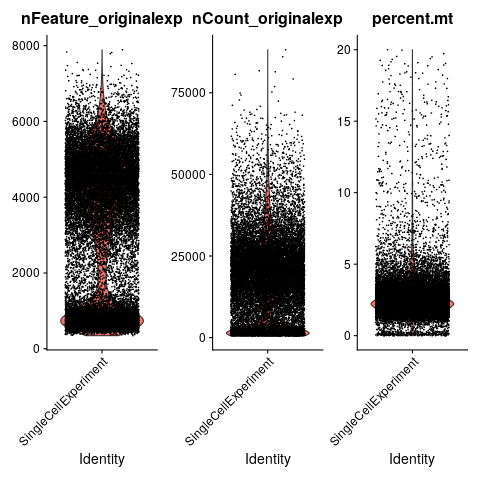

In [76]:
%%R 
adata_seurat <- PercentageFeatureSet(adata_seurat, pattern = "^MT-", col.name = "percent.mt")
VlnPlot(adata_seurat, features = c("nFeature_originalexp", "nCount_originalexp", "percent.mt"), ncol = 3, log=FALSE)

In [77]:
%%R
adata_seurat <- subset(adata_seurat, subset = nFeature_originalexp > 500 & nFeature_originalexp < 7000 & percent.mt < 5)
adata_seurat <- SCTransform(adata_seurat, assay="originalexp", verbose = FALSE, method = "glmGamPoi", vars.to.regress = c("percent.mt"))
adata_seurat

An object of class Seurat 
40107 features across 21601 samples within 2 assays 
Active assay: SCT (18786 features, 3000 variable features)
 1 other assay present: originalexp


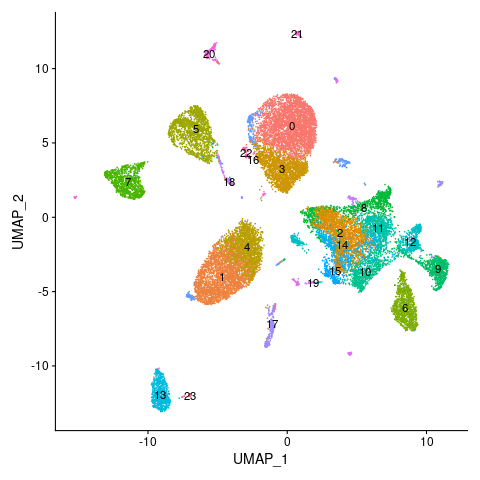

In [78]:
%%R
# These are now standard steps in the Seurat workflow for visualization and clustering
adata_seurat <- RunPCA(adata_seurat, verbose = FALSE)
adata_seurat <- RunUMAP(adata_seurat, dims = 1:30, verbose = FALSE)

adata_seurat <- FindNeighbors(adata_seurat, dims = 1:30, verbose = FALSE)
adata_seurat <- FindClusters(adata_seurat, verbose = FALSE)
DimPlot(adata_seurat, label = TRUE) + NoLegend()

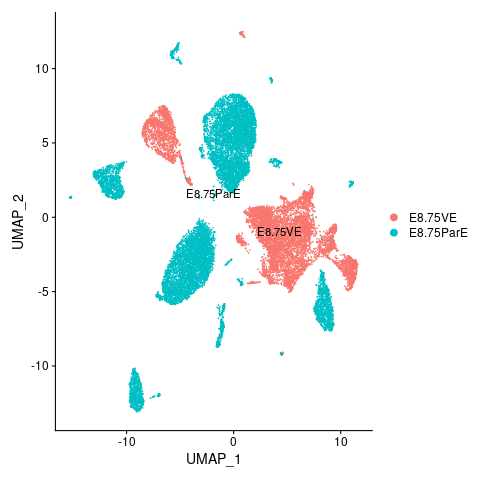

In [79]:
%%R
Idents(adata_seurat) <- "Stage"
DimPlot(adata_seurat, label = TRUE)

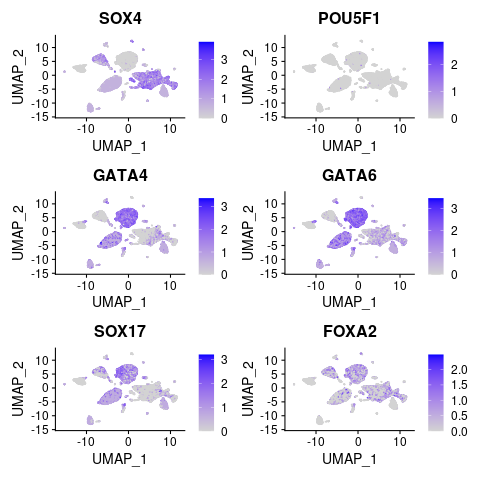

In [80]:
%%R
FeaturePlot(adata_seurat, features=c("SOX4", "POU5F1", "GATA4", "GATA6", "SOX17", "FOXA2"))

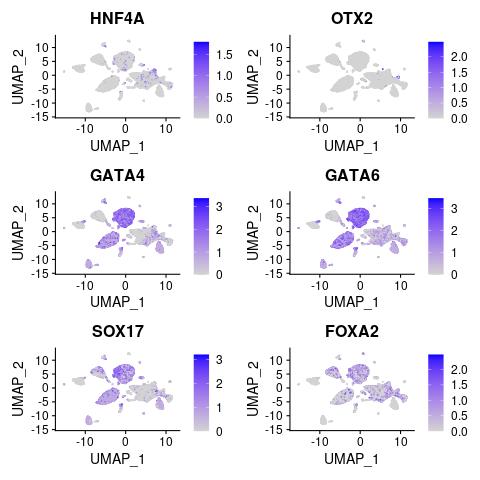

In [81]:
%%R
FeaturePlot(adata_seurat, features=c("HNF4A", "OTX2", "GATA4", "GATA6", "SOX17", "FOXA2"))

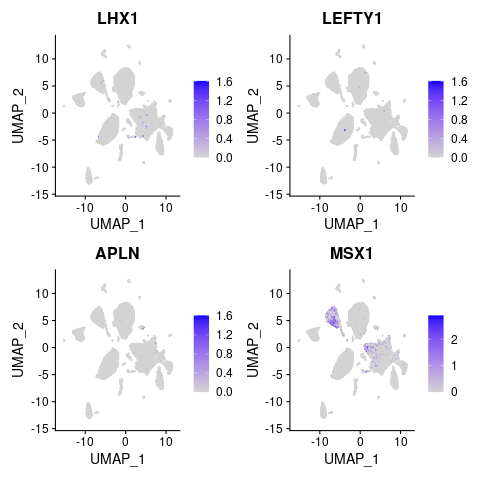

In [82]:
%%R
FeaturePlot(adata_seurat, features=c("LHX1", "LEFTY1", "APLN", "MSX1"))